# Logistic Regression Walkthrough

### Step 1: Import Python Libraries

In [33]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

### Step 2: Explore and Clean the Data

The dataset we are going to use is a [Heart Attack directory from Kaggle](https://www.kaggle.com/imnikhilanand/heart-attack-prediction/data?select=data.csv). The goal of the project is to predict the binary target, whether the patient has heart disease or not.

In [34]:
data = 'data.csv'
df = pd.read_csv(data, na_values='?')

In [35]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

In [36]:
# rename the target variable 'num' to target
df = df.rename(columns={'num       ':'target'})
df['target'].value_counts(dropna=False)

0    188
1    106
Name: target, dtype: int64

In [37]:
# the count suggests that the dataset is only slightly imbalanced among classes of 0 and 1
# so it is safe to proceed without special adjustment
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [38]:
# for simplicity, remove columns with many missing values
# then remove rows for columns with a few missing values
df = df.drop(['slope', 'ca', 'thal'], axis=1)
df = df.dropna().copy()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       261 non-null    int64  
 1   sex       261 non-null    int64  
 2   cp        261 non-null    int64  
 3   trestbps  261 non-null    float64
 4   chol      261 non-null    float64
 5   fbs       261 non-null    float64
 6   restecg   261 non-null    float64
 7   thalach   261 non-null    float64
 8   exang     261 non-null    float64
 9   oldpeak   261 non-null    float64
 10  target    261 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 24.5 KB


Features
- `age`: years
- `sex`: 1 for male, 0 for female
- `cp`: chest pain type
    - 1, typical angina
    - 2, atypical angina
    - 3, non-anginal pain
    - 4, asymptomatic
- `trestbps`: resting blood pressure; taken in mmHg on addmission
- `chol`: serum cholesterol in mg/dl
- `fbs`: fasting blood suger > 120 mg/dl; 1 for `True`, 0 for `False`
- `restecg`: resting electrocardiographic results
    - 0, normal
    - 1, abnormal ST-T wave; T-wave inversions a|o ST-elevation|-depression of > .05 mV
    - 2, probable|definite left ventricular hypertrophy by Estes' criteria
- `thalach`: max heart rate achieved
- `exang`: exercise-induced angina; 1 for yes, 0 for no
- `oldpeak`: ST-depession induced by exercise relative to rest

In [40]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,0
5,32,0,2,105.0,198.0,0.0,0.0,165.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160.0,331.0,0.0,0.0,94.0,1.0,2.5,1
290,54,0,3,130.0,294.0,0.0,1.0,100.0,1.0,0.0,1
291,56,1,4,155.0,342.0,1.0,0.0,150.0,1.0,3.0,1
292,58,0,2,180.0,393.0,0.0,0.0,110.0,1.0,1.0,1


5 Categorical Variables
 - `sex`
 - `cp`
 - `fbs`
 - `restecg`
 - `exang`

---
**_NOTE_**: In reality, more data cleaning and exploration should be done.

---

#### Step 3: Transform the Categorical Variables: Dummy Variables

> \
>*In logistic regression models, encoding all of the independent variables as dummy variables allows easy interpretation and calculation of the odds ratios, and increases the stability and significance of the coefficients. - UCLA* \
> &nbsp;

`sex`, `fbs`, and `exang` are already in a dummy variable format.

In [41]:
df['cp'].value_counts(dropna=False)

4    113
2     92
3     46
1     10
Name: cp, dtype: int64

In [42]:
df['restecg'].value_counts(dropna=False)

0.0    208
1.0     47
2.0      6
Name: restecg, dtype: int64

In [43]:
df = pd.get_dummies(df, columns=['cp', 'restecg'], drop_first=True) # drop_first because only 4 dummies are required for 5 variables, etc.

In [44]:
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_2,cp_3,cp_4,restecg_1.0,restecg_2.0
0,28,1,130.0,132.0,0.0,185.0,0.0,0.0,0,1,0,0,0,1
1,29,1,120.0,243.0,0.0,160.0,0.0,0.0,0,1,0,0,0,0
3,30,0,170.0,237.0,0.0,170.0,0.0,0.0,0,0,0,0,1,0
4,31,0,100.0,219.0,0.0,150.0,0.0,0.0,0,1,0,0,1,0
5,32,0,105.0,198.0,0.0,165.0,0.0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,160.0,331.0,0.0,94.0,1.0,2.5,1,0,0,1,0,0
290,54,0,130.0,294.0,0.0,100.0,1.0,0.0,1,0,1,0,1,0
291,56,1,155.0,342.0,1.0,150.0,1.0,3.0,1,0,0,1,0,0
292,58,0,180.0,393.0,0.0,110.0,1.0,1.0,1,1,0,0,0,0


`cp_1` was removed since it's not necessary to distinguish the classes of `cp`. The feature `restecg_2.0` was removed for the same reason.

In [45]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = list(set(df.columns) - set(numeric_cols) - {'target'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
['cp_2', 'cp_3', 'cp_4', 'exang', 'fbs', 'restecg_1.0', 'restecg_2.0', 'sex']


### Step 4: Split Training and Test Datasets

Split the original dataset into training and test datasets.

Using the `test_test_split` moethod, we will use:
- `test-size` as `0.20`, or 20% of the original dataset for testing
- `stratify` as `df['target']` to stratify borth the training and test datasets such that they will have similar portions of the target classes as the complete dataset, avoiding any imbalances in the dataset

In [46]:
# verify these specifications
random_seed = 888
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['target'])

In [47]:
print(df_train.shape)
print(df_test.shape)
print(df_train['target'].value_counts(normalize=True))
print(df_test['target'].value_counts(normalize=True))

(208, 14)
(53, 14)
0    0.625
1    0.375
Name: target, dtype: float64
0    0.622642
1    0.377358
Name: target, dtype: float64


### Step 5: Transform the Numerical Variables, Scaling

Create a class of `StandardScaler` and calculate (*fit*) the mean and standard deviation for scaling using `df_train`'s `numeric_cols`. Then we create a function `get_features_and_target_arrays` that...
- performs standardization on the `numeric_cols` of df to return the new array `X_numeric_scaled`,
- transforms `cat_cols` to a *Numpy* array `X_categorical`,
- combines both arrays back to the entire feature array `X`,
- and assigns the target column to `y`.

This step has to be completed after the `train_test_split` since the scaling calculations are based on the training dataset.

In [71]:
scaler = StandardScaler() # note that with_mean & with_std = False, meaning that the scaler scales all data to the existing mean and deviation
scaler.fit(df_train[numeric_cols])

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy() # converts df to a numpy array
    X = np.hstack((X_categorical, X_numeric_scaled)) # extends horizonally, results in 1 row
    y = df['target']
    return X, y

X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

### Step 6: Fit the Logistic Regression Model

In [49]:
clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function

clf.fit(X, y)

LogisticRegression(penalty='none')

### Step 7: Evaluate the Model

Use evaluation metrics for the dataset.

In [50]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

##### ROC Curve

The **ROC** (Reveiver Operating Characterisitic) curve plots the TPR against the FPR at different classification **thresholds**.

The **threshold** value determines the boundary between classes when using the classifier to predict. A value above a **threshold** can be classfiied as *Positive*, a value below is marked as *Negative*. Classification thresholds can vary within the same model.

- `True Positive Rate` is the ratio between all **True Positive** predictions and the total number of **Actual Positives** (TP + FN). Otherwise know as the `Recall` or `Sensitivity`.
- `False Positive Rate` is the ratio between all **False Positive** predictions and the total number of **Actual Negatives** (FP + TN).

The ideal model has an *ROC* curve that reaches the top left corner (0, 1) of the plot, or a TPR of 1 and an FPR of 0. Regardless of the outcome, the **AUC** (Area Under Curve) is the performance metric by which the model will be judged and it will evaluate to a number between 0 and 1.

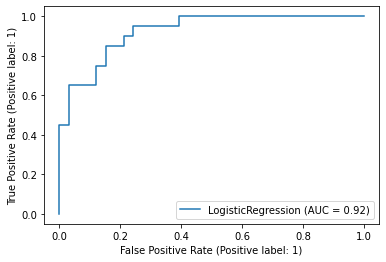

In [58]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test)

##### Precision-Recall Curve

The **Precision** of a model is the ratio between all **True Positive** predictions and the total number of **Predicted Positives** (TP + FP).

While a model can correctly predict all *Actual Positives* as **Positve** (increasing `recall`), it has a greater chance of predicting *True Negatives* as positive also (decreasing `precision`).

The `Precision-Recall` curve is moe informative than the *ROC* when the classes are imbalanced.

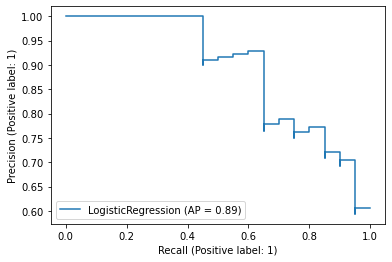

In [60]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

To calculate other metrics, we need to get the prediction results from the test dataset.
- `predict_proba` returns the predicted probability of the logistic regression for each class in the model. The first column of the output of `predict_proba` is P(`target=0`) and the second column is P(`target=1`).
- `predict` tests the dataset and chooses the class with the highest probability, which means a threshold of 0.5 in this binary example.

In [61]:
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

In [63]:
# {:.5f} to specify a conversion of the result to a float with 5 sigfigs
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.35613
AUC = 0.92424
Average Precision = 0.89045

Using 0.5 as threshold:
Accuracy = 0.83019
Precision = 0.76190
Recall = 0.80000
F1 score = 0.78049

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.76      0.80      0.78        20

    accuracy                           0.83        53
   macro avg       0.82      0.82      0.82        53
weighted avg       0.83      0.83      0.83        53



Also, it's a good idea to get the metrics from the training set for comparison. If the training set gives an accuracy that's much higher than the test dataset, overfitting could be an issue.

##### Confusion Matrix Using a Heatmap

Confusion Matrix


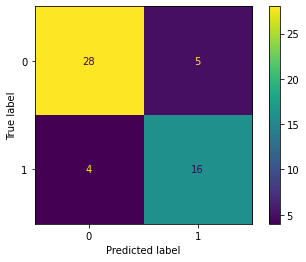

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

### Step 8: Interpret the Results

In [67]:
# grab the model intercept and coeffecients to print
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})

,variable,coefficient
0,intercept,-0.178340
1,cp_2,-2.895253
2,cp_3,-1.808676
3,cp_4,-0.830942
4,exang,0.514580
5,fbs,1.514143
6,restecg_1.0,-0.638990
7,restecg_2.0,-0.429625
8,sex,1.290292
9,age,0.059633


For `sex`, the model says that holding all other features at fixed values, the odds of having heart disease for males (`sex=1`) to the odds of having heart disease for females is...

$$for \ sex = 0, \ e^{1.290292} $$

For `cp` (chest pain type), the reference value is typical angina (`cp=1`). So the odds ratio of atypical angina (`cp=2`) to typical angina (`cp=1`) is...

$$for \ cp = 2, \ e^{-2.895253} $$

In [72]:
# next, display the numerical variables as standard deviations --> hence np.sqrt(variations)
pd.DataFrame(data={'variable': numeric_cols, 'unit': np.sqrt(scaler.var_)}) 

,variable,unit
0,age,7.909365
1,trestbps,18.039942
2,chol,63.470764
3,thalach,24.071915
4,oldpeak,0.891801


There is a 41% increase in the odds of having a heart disease for every *standard deviation* increase in `cholesterol` since `chol=0.345501`...

$$ for \ cholesterol = 63.470764, \ \\e^{0345501} = 1.41 $$